In [1]:
import lightning as L
import matplotlib.pyplot as plt
import torch
from lightning import seed_everything
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner
from torchvision import datasets
from torchvision import transforms

from src.module import ResNet, ResidualBlock

seed_everything(42, workers=True)

%matplotlib inline

Seed set to 42


In [2]:
download_dir = './data'

train_data = datasets.MNIST(
    root=download_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

valid_data = datasets.MNIST(
    root=download_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root=download_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [3]:
len(train_data), len(valid_data), len(test_data)

(60000, 10000, 10000)

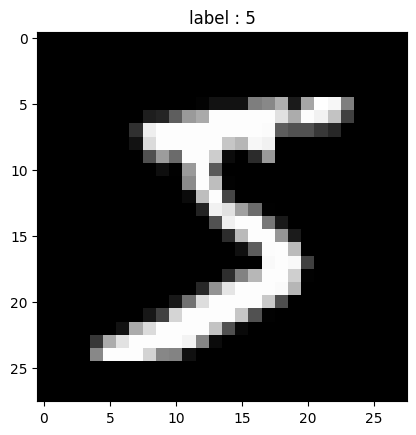

In [4]:
# Sometimes, plot doesn't work cuz I included normaliser and auto augment function.
image, label = train_data[0]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f'label : {label}')
plt.show()

In [5]:
# I already ready for dataloader in the lightning module.
# So delete the class.
del train_data, valid_data, test_data, image, label

### Training with LearningRateFinder.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [7]:
trainer = L.Trainer(
    max_epochs=20,
    callbacks=[EarlyStopping(monitor="val_acc", min_delta=1e-2, patience=5, verbose=True, mode='min')],
)
tuner = Tuner(trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\aksid\PycharmProjects\MNISTClassifier\venv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [8]:
model = ResNet(block=ResidualBlock, layers=[3, 4, 6, 3], device=device.type)
model.to(device)
device

device(type='cuda')

In [9]:
# tuner.scale_batch_size(model, init_val=2 ** 15)

You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0004365158322401656
Restoring states from the checkpoint path at C:\Users\aksid\PycharmProjects\MNISTClassifier\.lr_find_0050922d-e22a-498c-8b4b-efcbfbfc8310.ckpt
Restored all states from the checkpoint at C:\Users\aksid\PycharmProjects\MNISTClassifier\.lr_find_0050922d-e22a-498c-8b4b-efcbfbfc8310.ckpt


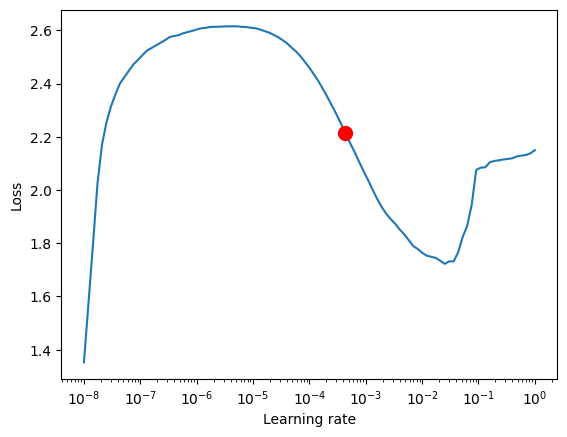

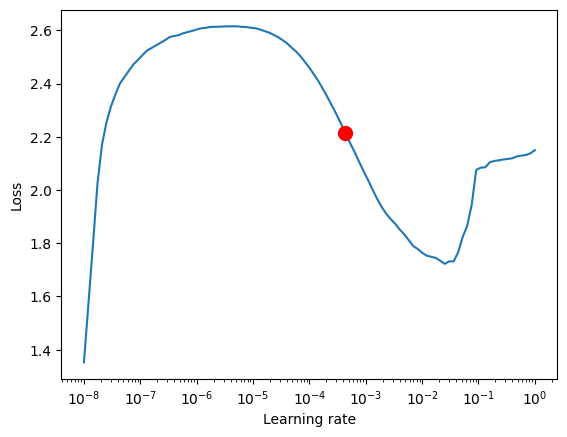

In [10]:
lr_finder = tuner.lr_find(model)

lr_finder.plot(suggest=True)

In [11]:
del lr_finder, tuner

In [12]:
model.hparams.batch_size, model.hparams.learning_rate

(1024, 0.0004365158322401656)

In [13]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type               | Params
-------------------------------------------------
0  | loss     | CrossEntropyLoss   | 0     
1  | accuracy | MulticlassAccuracy | 0     
2  | conv1    | Conv2d             | 3.1 K 
3  | bn1      | BatchNorm2d        | 128   
4  | relu     | ReLU               | 0     
5  | maxpool  | MaxPool2d          | 0     
6  | layer1   | Sequential         | 221 K 
7  | layer2   | Sequential         | 1.1 M 
8  | layer3   | Sequential         | 6.8 M 
9  | layer4   | Sequential         | 13.1 M
10 | avgpool  | AdaptiveAvgPool2d  | 0     
11 | fc       | Linear             | 5.1 K 
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.134    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.910


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.910. Signaling Trainer to stop.


In [14]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9692000150680542     │
│         test_loss         │    0.09890630841255188    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09890630841255188, 'test_acc': 0.9692000150680542}]

### Save the model

In [15]:
trainer.save_checkpoint('mnist.model')